In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

In [5]:
num_epochs = 7
batch_size = 20
learning_rate = 0.001

In [6]:
augmentation_transform = transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                    transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                    transforms.ToTensor(),
                                    transforms.Normalize( 
                                       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
                                    )
])

In [7]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])

In [8]:
original_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

augmented_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=augmentation_transform)

print(len(original_trainset))
print(len(augmented_trainset))

combined_train_dataset = torch.utils.data.ConcatDataset([original_trainset, augmented_trainset])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 63348296.76it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
50000
50000
Files already downloaded and verified


In [9]:
train_loader = torch.utils.data.DataLoader(combined_train_dataset, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)
n_total_step = len(train_loader)

print(n_total_step)

5000


In [13]:
model = models.vgg16(weights = True)

In [14]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
input_size_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_size_lastLayer,10)
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

In [11]:
for epoch in range(num_epochs):
    for i, (imgs , labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 250 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
print()

epoch 1/7, step: 250/2500: loss = 0.94724, acc = 75.00%
epoch 1/7, step: 500/2500: loss = 0.88787, acc = 70.00%
epoch 1/7, step: 750/2500: loss = 0.49012, acc = 80.00%
epoch 1/7, step: 1000/2500: loss = 0.55616, acc = 85.00%
epoch 1/7, step: 1250/2500: loss = 0.42223, acc = 80.00%
epoch 1/7, step: 1500/2500: loss = 1.08552, acc = 60.00%
epoch 1/7, step: 1750/2500: loss = 0.52517, acc = 90.00%
epoch 1/7, step: 2000/2500: loss = 0.40179, acc = 85.00%
epoch 1/7, step: 2250/2500: loss = 0.41653, acc = 90.00%
epoch 1/7, step: 2500/2500: loss = 0.45659, acc = 85.00%
epoch 2/7, step: 250/2500: loss = 0.84745, acc = 70.00%
epoch 2/7, step: 500/2500: loss = 0.67358, acc = 75.00%
epoch 2/7, step: 750/2500: loss = 0.68175, acc = 85.00%


KeyboardInterrupt: 

In [17]:
import copy

def train_model(model, train_data, optimizer, criterion, epochs=12, val_data=None, early_stopping=False, early_stopping_patience=5):
    """
        Reusable function to train a pytorch model.
        
        Input:
            model: PyTorch Model
            train_data: DataSet Loader with Train Data
            epochs: (default = 12) Number of epochs the model should be trained
            val_data: (Optional) DataSet Loader with Validation Data to perform the model on unseen data
            early_stopping: (default = False) Whether the training should stop early to avoid overfitting
            early_stopping_patience: (default = 5) Patience value for early stopping
            
        Returns:
            model: PyTorch model trained on the given data
            history: History of the values containing, Train loss, Train Accuracy, Val Loss and Val Accuracy (If validation data provided)
    
    """
    
    if val_data is None and early_stopping is True:
        raise ValueError("Early stopping is done based on the models performance on validation data, so inorder to perform early stopping, pass in validation data or set early_stopping = False")
    
    
    train_loader = train_data
    val_loader = val_data
    
    best_loss = float('inf')
    best_model_weights = None
    best_model_weights = copy.deepcopy(model.state_dict())
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []
    
    for epoch in range(epochs):
        
        model.train() # model in train mode
        
        train_losses = []
        train_correct = 0
        train_total = 0
        
        for batch_num, input_data in enumerate(train_loader):
            optimizer.zero_grad()

            x, y = input_data
            x = x.to(device).float()
            y = y.to(device)

            output = model(x)

            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            _, predicted = torch.max(output.data, 1)
            train_total += y.size(0)
            train_correct += (predicted == y).sum().item()

            if batch_num % 500 == 0:
                print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch+1, batch_num, loss.item()))

        train_avg_loss = sum(train_losses) / len(train_losses)
        train_accuracy = 100 * train_correct / train_total
        print('Epoch %d | Training Loss %6.2f | Training Accuracy: %2.2f %%' % (epoch+1, train_avg_loss, train_accuracy))
        history['train_loss'].append(train_avg_loss)
        history['train_accuracy'].append(train_accuracy)

        if val_loader is not None:
            # Validation phase
            model.eval()
            
            val_losses = []
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                for batch_num, val_data in enumerate(val_loader):
                    x, y = val_data
                    x = x.to(device).float()
                    y = y.to(device)

                    val_output = model(x)
                    val_loss = criterion(val_output, y)
                    val_losses.append(val_loss.item())
                    _, val_predicted = torch.max(val_output.data, 1)
                    val_total += y.size(0)
                    val_correct += (val_predicted == y).sum().item()

            val_avg_loss = sum(val_losses) / len(val_losses)
            val_accuracy = 100 * val_correct / val_total
            print('Epoch %d | Validation Loss %6.2f | Validation Accuracy: %2.2f %%' % (epoch+1, val_avg_loss, val_accuracy))
            history['val_loss'].append(val_avg_loss)
            history['val_accuracy'].append(val_accuracy)

        if early_stopping is not False:
            # Early stopping
            if val_avg_loss < best_loss:
                best_loss = val_avg_loss
                best_model_weights = copy.deepcopy(model.state_dict())  # Deep copy here 
                patience = early_stopping_patience  # Reset patience counter
                print(f"Saving the best model at {epoch+1}th epoch.")
            else:
                patience -= 1
                if patience == 0:
                    print(f"Stopping the training")
                    break

    # Load the best model weights
    model.load_state_dict(best_model_weights)
    
    return model, history

In [18]:
model, history = train_model(model, train_loader, optimizer, criterion, num_epochs, test_loader,  True, 3)

	Epoch 1 | Batch 0 | Loss   2.62
	Epoch 1 | Batch 500 | Loss   0.78
	Epoch 1 | Batch 1000 | Loss   0.70
	Epoch 1 | Batch 1500 | Loss   0.28
	Epoch 1 | Batch 2000 | Loss   0.63
	Epoch 1 | Batch 2500 | Loss   0.23
	Epoch 1 | Batch 3000 | Loss   0.37
	Epoch 1 | Batch 3500 | Loss   0.62
	Epoch 1 | Batch 4000 | Loss   0.30
	Epoch 1 | Batch 4500 | Loss   0.39
Epoch 1 | Training Loss   0.41 | Training Accuracy: 85.91 %
Epoch 1 | Validation Loss   0.26 | Validation Accuracy: 91.39 %
Saving the best model at 1th epoch.
	Epoch 2 | Batch 0 | Loss   0.15
	Epoch 2 | Batch 500 | Loss   0.04
	Epoch 2 | Batch 1000 | Loss   0.26
	Epoch 2 | Batch 1500 | Loss   0.08
	Epoch 2 | Batch 2000 | Loss   0.07
	Epoch 2 | Batch 2500 | Loss   0.22
	Epoch 2 | Batch 3000 | Loss   0.15
	Epoch 2 | Batch 3500 | Loss   0.09
	Epoch 2 | Batch 4000 | Loss   0.05
	Epoch 2 | Batch 4500 | Loss   0.21
Epoch 2 | Training Loss   0.20 | Training Accuracy: 93.08 %
Epoch 2 | Validation Loss   0.23 | Validation Accuracy: 92.46 %
Savi

In [19]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')

Overall accuracy 94.04%


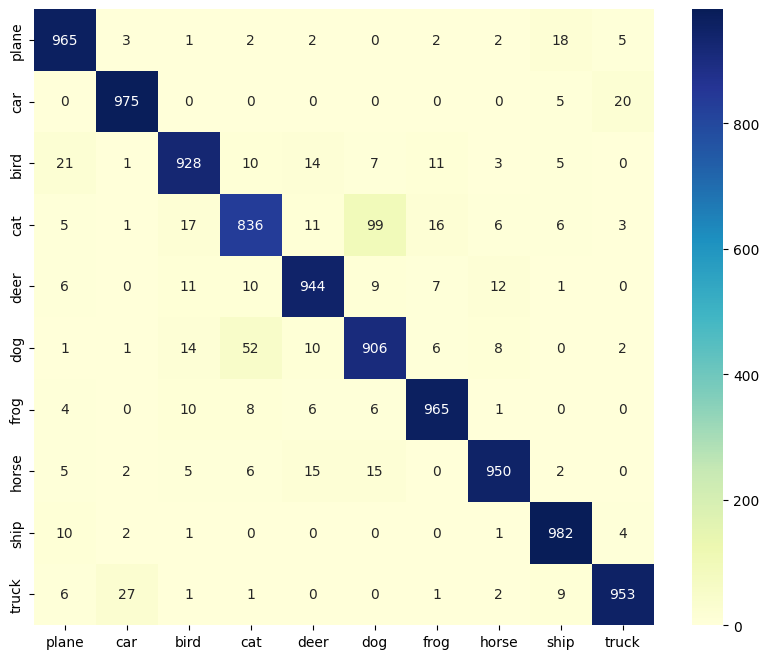

In [20]:
heatmap = pd.DataFrame(data=0,index=classes,columns=classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            true_label = labels[i].item()
            predicted_label = predicted[i].item()
            heatmap.iloc[true_label,predicted_label] += 1
_, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(heatmap, annot=True, fmt="d",cmap="YlGnBu")
plt.show()